### Importing

In [1]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import random

### Loading pic

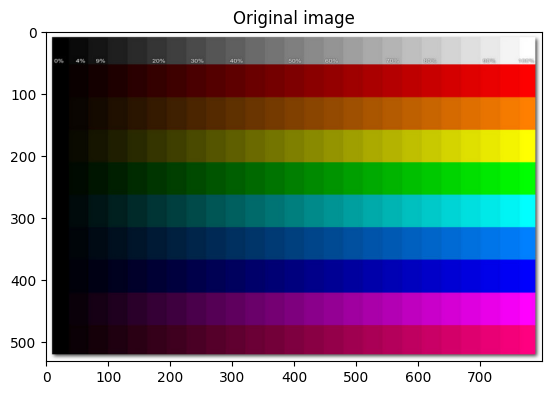

In [2]:
image = cv2.imread("index.png")
b,g,r = cv2.split(image)       # get b,g,r
rgb_image = cv2.merge([r,g,b])     # switch it to rgb
plt.imshow(rgb_image)
plt.title("Original image")
plt.show()

### Peaked filter

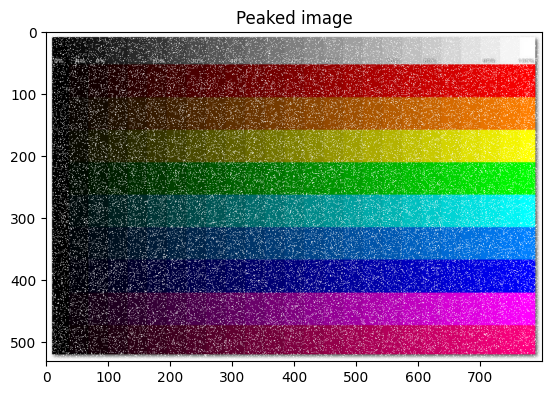

In [3]:
def add_peaksRGB(img, percent):
    (b, g, r) = cv2.split(image)
    for x in range(b.shape[0]):
        for y in range(b.shape[1]):
            if random.randint(1,100)<percent:
                b[x, y] = 255
                g[x, y] = 255
                r[x, y] = 255
    merged_rgb = cv2.merge([r,g,b])
    merged_bgr = cv2.merge([b,g,r]) 
    plt.imshow(merged_rgb)
    plt.title("Peaked image")
    plt.show()
    return merged_bgr
peaksImage = add_peaksRGB(image, 10) #Здесь можно задать проценты

### Salt and pepper filter

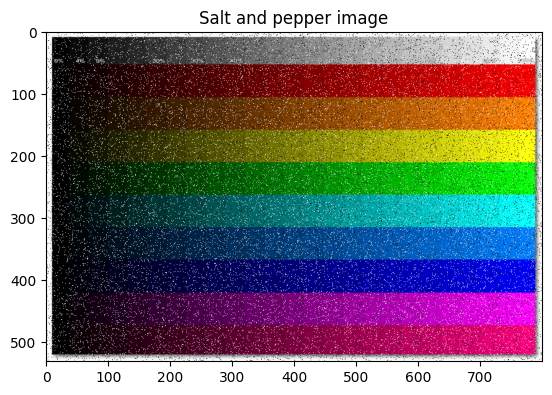

In [5]:
def add_spiceRGB(img, percent):
    (b, g, r) = cv2.split(image)
    for x in range(b.shape[0]):
        for y in range(b.shape[1]):
            if random.randint(1,100)<percent:
                spice = random.randint(0,1)*255
                b[x, y] = spice
                g[x, y] = spice
                r[x, y] = spice
    merged_rgb = cv2.merge([r,g,b])
    merged_bgr = cv2.merge([b,g,r]) 
    plt.imshow(merged_rgb)
    plt.title("Salt and pepper image")
    plt.show()
    return merged_bgr
seasonedImage = add_spiceRGB(image, 10) #Здесь тоже можно задать проценты

### Loading universal functions

In [6]:
def convolve(arr1, arr2):
    res = np.sum(np.multiply(arr1,arr2))
    if res>255:
        res=255
    elif res<0:
        res=0
    return int(res)
def extendColor(arr, side):
    #Самым ублюдским способом приклеиваем последнюю полоску пикселей с кадого края изображения
    arr = np.vstack([np.array([arr.T[0]]*(side//2)), arr.T, np.array([arr.T[arr.T.shape[0]-1]]*(side//2))], dtype='uint8') 
    arr = np.vstack([np.array([arr.T[0]]*(side//2)), arr.T, np.array([arr.T[arr.T.shape[0]-1]]*(side//2))], dtype='uint8')
    return arr

### Gaussian blur
Это может быть немного долго

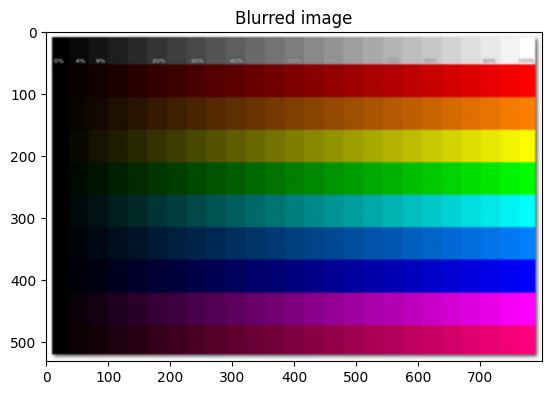

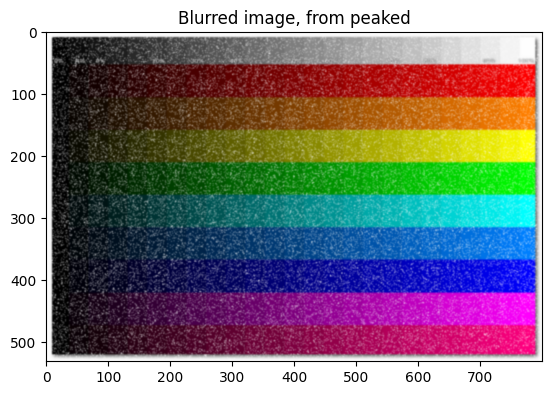

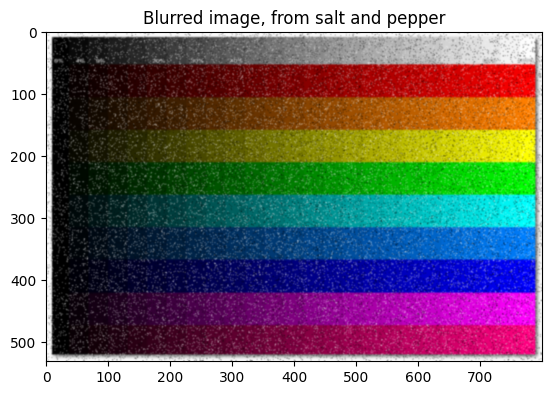

In [7]:
def gauss(x, sigma):
    return 1/np.sqrt(2*3.1416*sigma**2)*np.exp(-(x**2)/(2*sigma**2))
def blur(side, arr):
    sigma = (side-1)/6 if side>3 else 0.6
    diap = np.linspace(-(side - 1) / 2, (side - 1) / 2, side) #Задаем по стороне фильтра диап для генерации ядра типа [-2,-1,0,1,2]
    d1kern = np.array(list(map(gauss, diap, [sigma]*len(diap)))) #Считаем  1мерное ядро 
    newarr = np.zeros(arr.shape, dtype = "uint8") #Делаем пустой массив размером с нашу картинку
    kern = np.outer(d1kern, d1kern) #Перемножением 1d ядер делаем 2d ядро
    arr = extendColor(arr, side)
   #Производим свертку, проходясь по каждому пикселю исходного изображения
    for y in range(side//2, arr.shape[1]-side//2):
        for x in range(side//2, arr.shape[0]-side//2):
            sub = arr[x-side//2:(x+side//2+1), y-side//2:(y+side//2+1)]
            newarr[x-side//2,y-side//2] = convolve(sub, kern)
    return newarr
def blurRGB(image, side):
    (b, g, r) = cv2.split(image)
    b = blur(side, b)
    g = blur(side, g)
    r = blur(side, r)
    merged_rgb = cv2.merge([r,g,b])
    merged_bgr = cv2.merge([b,g,r]) 
    plt.imshow(merged_rgb)
    plt.show()
    return merged_bgr
plt.title("Blurred image")
blurred = blurRGB(image, 7)
plt.title("Blurred image, from peaked")
_ = blurRGB(peaksImage,7)
plt.title("Blurred image, from salt and pepper")
_ = blurRGB(seasonedImage,7)

### Sharpening

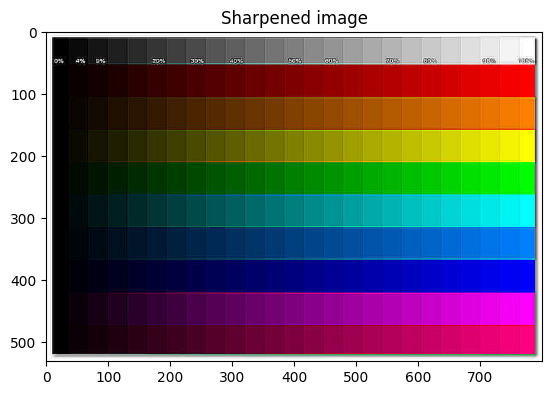

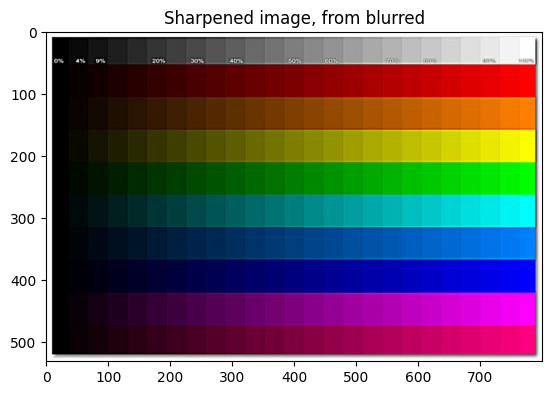

In [9]:
def sharp(arr, side=3):
    kern = -np.ones((side,side))
    kern[side//2,side//2]=side**2
    newarr = np.zeros(arr.shape, dtype = "uint8") #Делаем пустой массив размером с нашу картинку
    arr = extendColor(arr, side)
    for y in range(side//2, arr.shape[1]-side//2):
        for x in range(side//2, arr.shape[0]-side//2):
            sub = arr[x-side//2:(x+side//2+1), y-side//2:(y+side//2+1)]
            newarr[x-side//2,y-side//2] = convolve(sub, kern)
    return newarr
def sharpRGB(image, side):
    (b, g, r) = cv2.split(image)
    b = sharp(b, side)
    g = sharp(g, side)
    r = sharp(r, side)
    merged_rgb = cv2.merge([r,g,b])
    plt.imshow(merged_rgb)
    plt.show()

plt.title("Sharpened image")
sharpRGB(image, 3)
plt.title("Sharpened image, from blurred")
sharpRGB(blurred, 3)

### Median

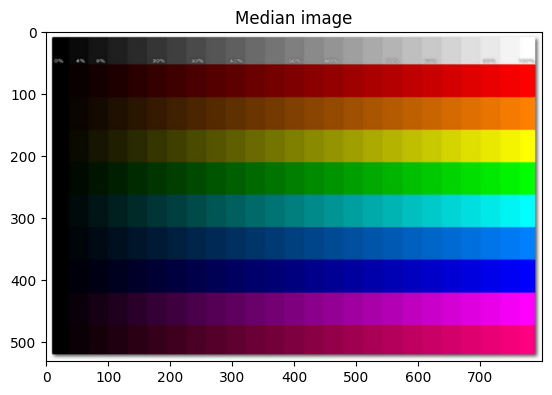

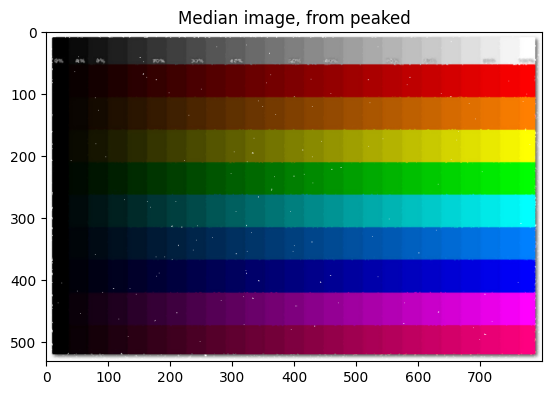

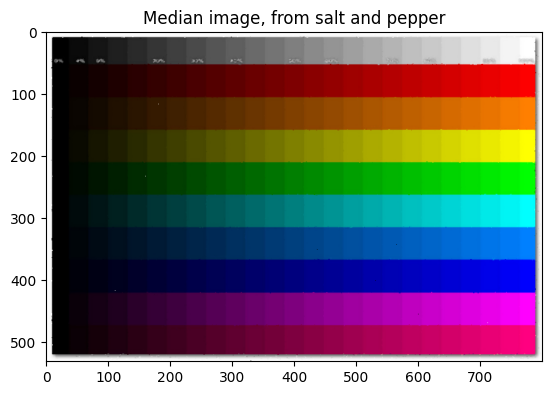

In [10]:
def median(arr, side=3):
    newarr = np.zeros(arr.shape, dtype = "uint8") #Делаем пустой массив размером с нашу картинку
    arr = extendColor(arr, side)
    for y in range(side//2, arr.shape[1]-side//2):
        for x in range(side//2, arr.shape[0]-side//2):
            sub = arr[x-side//2:(x+side//2+1), y-side//2:(y+side//2+1)]
            newarr[x-side//2,y-side//2] = np.sort(sub.flatten())[side**2//2]
    return newarr
def medianRGB(image, side):
    (b, g, r) = cv2.split(image)
    b = median(b, side)
    g = median(g, side)
    r = median(r, side)
    merged_rgb = cv2.merge([r,g,b])
    plt.imshow(merged_rgb)
    plt.show()
plt.title("Median image")
medianRGB(image, 3)
plt.title("Median image, from peaked")
medianRGB(peaksImage, 3)
plt.title("Median image, from salt and pepper")
medianRGB(seasonedImage, 3)